In [ ]:
# -*- coding: utf-8 -*-
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or
# implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#


# Transfer learning and fine tuning pytorch

Source: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

Time to run: 30 min on CPU

In [16]:
# first time install
# !pip install torch numpy torchvision matplotlib

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

### Load Data

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Visualize a few images

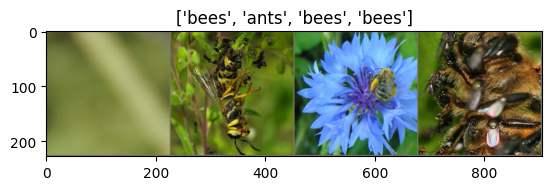

In [4]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the model

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

### Visualizing the model predictions

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

#### Finetuning the ConvNet

In [7]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\alexe/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


### Train and evaluate

In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5618 Acc: 0.7541
val Loss: 0.2921 Acc: 0.8889

Epoch 1/24
----------
train Loss: 0.6665 Acc: 0.7131
val Loss: 0.1855 Acc: 0.9085

Epoch 2/24
----------
train Loss: 0.3592 Acc: 0.8607
val Loss: 0.2589 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.6279 Acc: 0.7541
val Loss: 0.4328 Acc: 0.8301

Epoch 4/24
----------
train Loss: 0.5104 Acc: 0.8115
val Loss: 0.2978 Acc: 0.8954

Epoch 5/24
----------
train Loss: 0.5043 Acc: 0.7910
val Loss: 0.3180 Acc: 0.8954

Epoch 6/24
----------
train Loss: 0.3890 Acc: 0.8402
val Loss: 0.2691 Acc: 0.8954

Epoch 7/24
----------
train Loss: 0.3011 Acc: 0.8525
val Loss: 0.2373 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.3395 Acc: 0.8730
val Loss: 0.2312 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.2988 Acc: 0.8770
val Loss: 0.2200 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.4239 Acc: 0.8033
val Loss: 0.2581 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.3274 Acc: 0.8607
val Loss: 0.2165 Acc: 0.9216

Ep

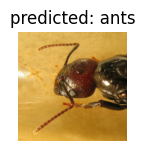

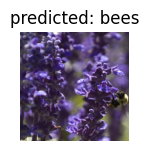

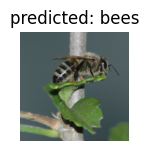

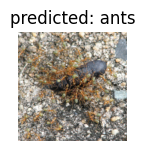

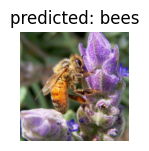

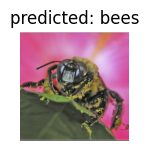

In [9]:
visualize_model(model_ft)

### ConvNet as fixed feature extractor

In [10]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

## Train and evaluate

In [11]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6927 Acc: 0.6516
val Loss: 0.2420 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.5011 Acc: 0.7582
val Loss: 0.2122 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.4290 Acc: 0.8279
val Loss: 0.2115 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.4530 Acc: 0.8033
val Loss: 0.1833 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.4619 Acc: 0.8033
val Loss: 0.1757 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.4538 Acc: 0.8238
val Loss: 0.3365 Acc: 0.8889

Epoch 6/24
----------
train Loss: 0.5355 Acc: 0.8033
val Loss: 0.1599 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.3058 Acc: 0.8934
val Loss: 0.1882 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3100 Acc: 0.8648
val Loss: 0.1619 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3476 Acc: 0.8525
val Loss: 0.1615 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3362 Acc: 0.8484
val Loss: 0.1721 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.4024 Acc: 0.8361
val Loss: 0.1915 Acc: 0.9412

Ep

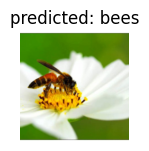

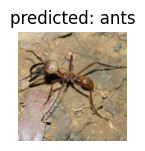

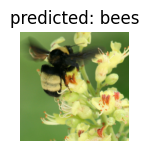

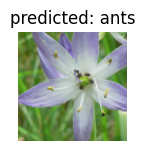

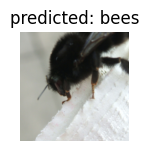

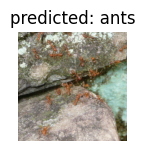

In [12]:
visualize_model(model_conv)

plt.ioff()
plt.show()

### Inference on custom images

In [13]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

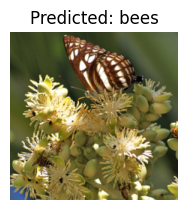

In [14]:
visualize_model_predictions(
    model_conv,
    img_path='data/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()